In [24]:
import pandas as pd #needed to import dataset

# Load a CSV file
full = pd.read_csv("C:/Users/annaw/Desktop/DataScience/Datasets/full_dataset.csv",
    dtype={91: str})



In [15]:
#Building a binary classifier to predict whether an avalanche will occur (1) or not (0)
#Based on environmental features - for example: snow, temperature, water, radiation,...

In [25]:
# Basic info
print(full.info())  # data types, missing values
print(full.head())  # first few rows
print(full.describe())  # statistics for numerical columns

# Check for missing values
print(full.isnull().sum())

# drop columns with >20% missing
full_clean = full.dropna(thresh=len(full)*0.8, axis=1)  
print(full_clean.info())  # data types, missing values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11362 entries, 0 to 11361
Data columns (total 95 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   datum                  11362 non-null  object 
 1   station_code           11362 non-null  object 
 2   aspect                 11362 non-null  float64
 3   elevation              11362 non-null  float64
 4   avalancheDay1          11362 non-null  int64  
 5   max_height             11362 non-null  float64
 6   TSS_mod                11362 non-null  float64
 7   prop_base_3_diff       11362 non-null  float64
 8   ILWR_daily             11362 non-null  float64
 9   RH_daily               11362 non-null  float64
 10  ISWR_diff_daily        11362 non-null  float64
 11  prop_base_1_diff       11362 non-null  float64
 12  prop_wet_2_diff        11362 non-null  float64
 13  prop_wet_3_diff        11362 non-null  float64
 14  max_height_3_diff      11362 non-null  float64
 15  lo

In [26]:
###### Random forest to find important features

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import plot_confusion_matrix,
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix
from matplotlib.pylab import rcParams
from sklearn.preprocessing import StandardScaler


In [42]:
#Clean the dataset (no NA, no non numerical, no Year, no datum)

# Drop non-numeric columns and missing data
full_clean = full_clean.dropna()  # drop rows with missing values

#Only use numerical values
full_clean = full_clean.select_dtypes(include=[np.number])

# Exclude "year' and 'datum'
full_clean = full_clean.drop(columns=[col for col in ['year', 'datum'] if col in full_clean.columns])

In [43]:
#We might want to keep month
#Then we would need to do that

# Encode categorical variables - models can only use numbers not text
#categorical_cols = full_clean.select_dtypes(include='object').columns
#full_encoded = pd.get_dummies(full_clean, columns=categorical_cols, drop_first=True)

In [44]:
# Split features and target
X = full_encoded.drop(columns=["avalancheDay1"])   # all columns except the target
y = full_encoded["avalancheDay1"]  # avalanche label: 1 = avalanche, 0 = no avalanche

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
# Train Decision Tree Classifier
clf_tree = DecisionTreeClassifier(max_depth=4, random_state=42)
clf_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

Decision Tree Evaluation:
[[1923    0]
 [ 136    0]]
              precision    recall  f1-score   support

           0       0.93      1.00      0.97      1923
           1       0.00      0.00      0.00       136

    accuracy                           0.93      2059
   macro avg       0.47      0.50      0.48      2059
weighted avg       0.87      0.93      0.90      2059



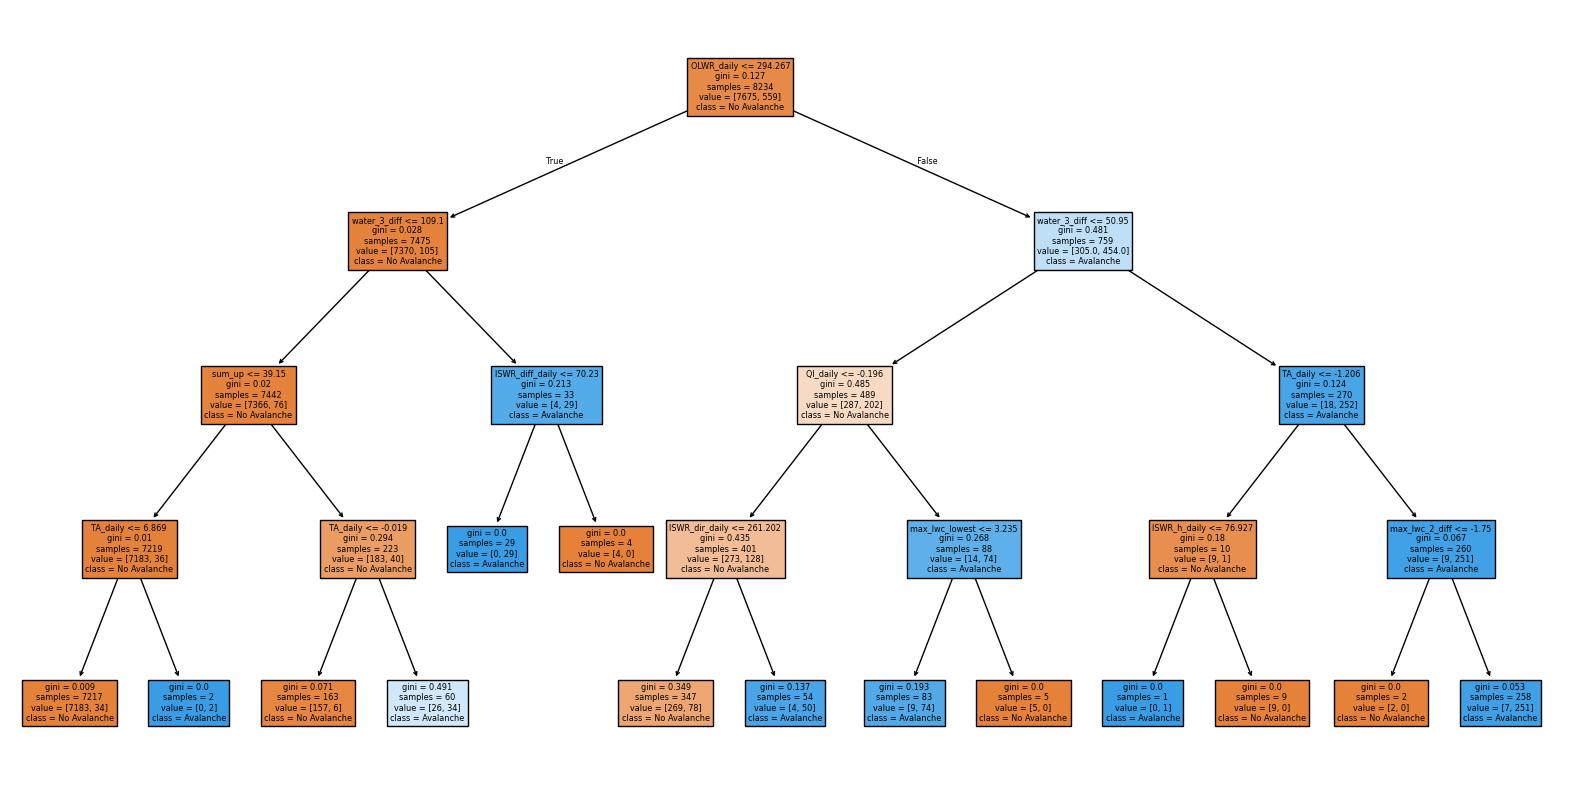

In [46]:
# Predict and evaluate
y_pred_tree = clf_tree.predict(X_test_scaled) #predicts labels on the test set given the decision tree
print("Decision Tree Evaluation:")
print(confusion_matrix(y_test, y_pred_tree)) # confusion matrix
print(classification_report(y_test, y_pred_tree)) # precision, recall, f1, support

# Plot tree
plt.figure(figsize=(20, 10))
plot_tree(clf_tree, feature_names=X.columns, class_names=['No Avalanche', 'Avalanche'], filled=True)
plt.show()

#[[1923    0]   → True Negatives / False Positives
#[ 136   0]]  → False Negatives / True Positives

#Accuracy is really high (93%)
#BUT: Avalanche recall is very low --> NO avalanche days were correctly identified :/

# plotted tree shows how feature splits lead to predictions

# PROBLEM
# The model is heavily biased toward the majority class (no avalanche)

# Avalanches are rare --> strong class imbalance
# Decision Trees (especially shallow ones like max_depth=4) tend to underfit minority classes
# The model plays it save by mostly predicting NO avalanche days

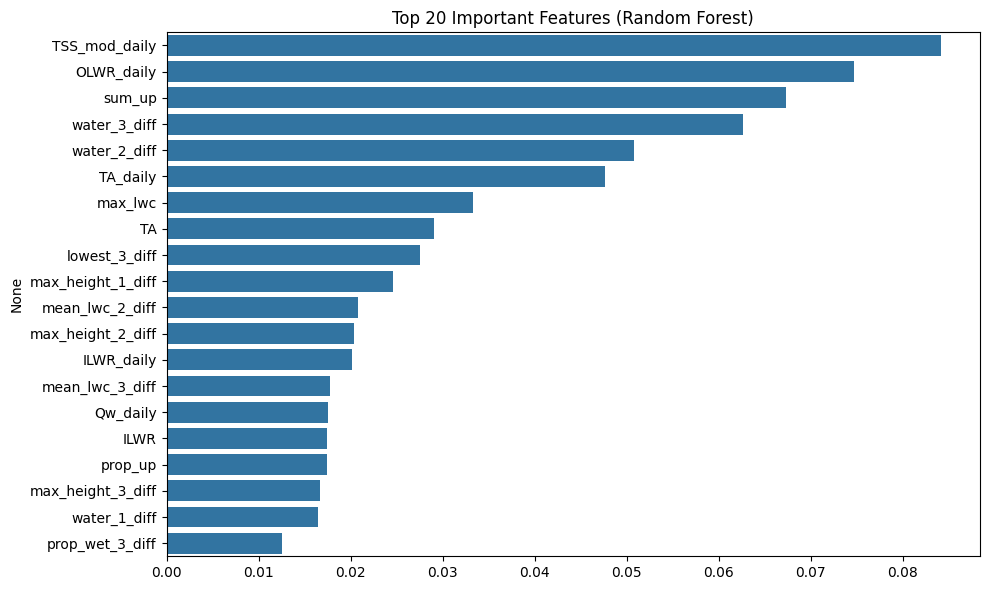

In [47]:
# Train Random Forest with 100 trees
clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
clf_rf.fit(X_train_scaled, y_train)

# Feature importance
importances = clf_rf.feature_importances_
indices = np.argsort(importances)[::-1]
top_features = X.columns[indices][:20]

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices][:20], y=top_features)
plt.title("Top 20 Important Features (Random Forest)")
plt.tight_layout()
plt.show()

# Feature: Meaning / Why It Matters
# TSS_mod_daily: Snow surface temperature → affects melt/refreeze cycles
# OLWR_daily: Outgoing longwave radiation → linked to energy balance
# water_3_diff: Water content in layer 3 (deep snow) → potential instability
# TA_daily: Air temperature → critical for thawing/freezing
# ILWR / ILWR_daily: Incoming longwave radiation → heat exchange

#These features make sense in avalanche science 
#temperature, water content, and radiation balance are known triggers or indicators of unstable snowpack conditions

#!!
# Non-causal: These variables correlate with avalanche risk — they do not necessarily cause avalanches

Random Forest Evaluation:
[[1921    2]
 [  16  120]]
              precision    recall  f1-score   support

No Avalanche       0.99      1.00      1.00      1923
   Avalanche       0.98      0.88      0.93       136

    accuracy                           0.99      2059
   macro avg       0.99      0.94      0.96      2059
weighted avg       0.99      0.99      0.99      2059



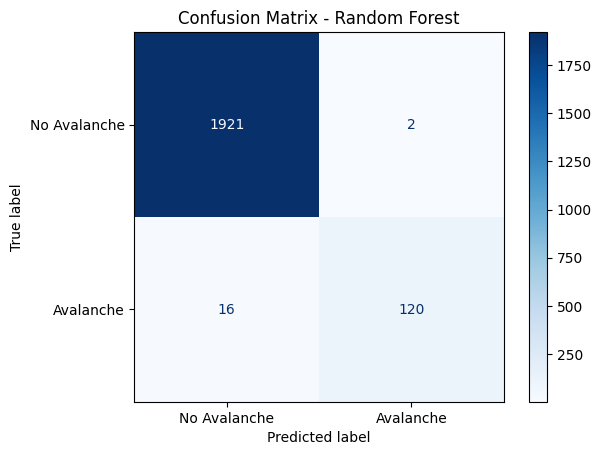

Random Forest Accuracy: 0.99


In [48]:
# Predict with Random Forest
#Predicts avalanche (1) or no avalanche (0) on the test set
y_pred_rf = clf_rf.predict(X_test_scaled)

# Evaluate Random Forest
print("Random Forest Evaluation:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)
print(classification_report(y_test, y_pred_rf, target_names=["No Avalanche", "Avalanche"]))

#True Negatives (TN): 1921 → Correctly predicted no avalanche
#False Positives (FP): 2 → Predicted avalanche, but none happened (In real world - OK - better safe than sorry)
#False Negatives (FN): 16 → Predicted no avalanche, but avalanche happened (NOT GOOD)
#True Positives (TP): 120 → Correctly predicted avalanche 

# Confusion Matrix Display
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["No Avalanche", "Avalanche"])
disp_rf.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

#Precision (Avalanche): 0.98  
#98% of predicted avalanches were correct

# Recall (Avalanche): 0.88
# 98% of actual avalanches were detected

# F1 Score (Avalanche): 0.93
# Very strong harmonic mean of precision & recall.

# Overall Accuracy: 0.99 (amazing — but secondary to look at for risk prediction)
# Why risk prediction: 
# Accuracy can be misleading, especially when the event you're trying to predict (like an avalanche) is rare == Avalanche
#How many avalanches did we NOT chatch - 12% !!!

# Accuracy
accuracy_rf = clf_rf.score(X_test_scaled, y_test)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

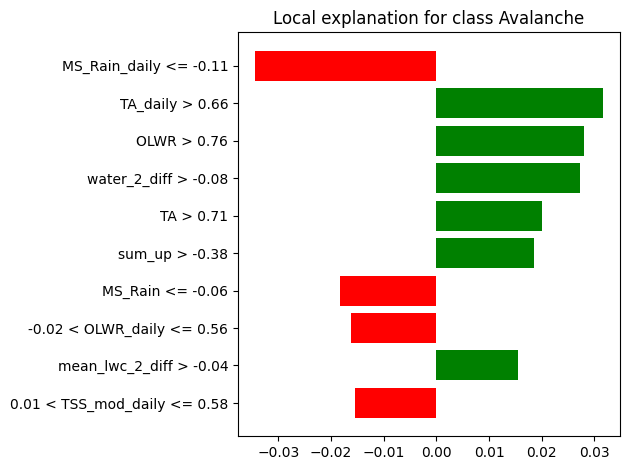

In [49]:
#LIME = shows what pushed the prediction toward "Avalanche" or "No Avalanche" for a specific day

import lime
import lime.lime_tabular

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X.columns,
    class_names=['No Avalanche', 'Avalanche'],
    mode='classification'
)

# Choose a test instance to explain (e.g. the 5th test sample)
# LIME only explains one data point at a time
# X_test_scaled[i] == one specific test sample (a day with certain snow/weather values)

# runs LIME to explain why it was classified as either "Avalanche" or "No Avalanche"
i = 5
exp = explainer.explain_instance(X_test_scaled[i], clf_rf.predict_proba, num_features=10)


# Show explanation in notebook or plot
exp.show_in_notebook(show_table=True)

# or plot it
# Local feature importance plot.
fig = exp.as_pyplot_figure()
plt.tight_layout()
plt.show()


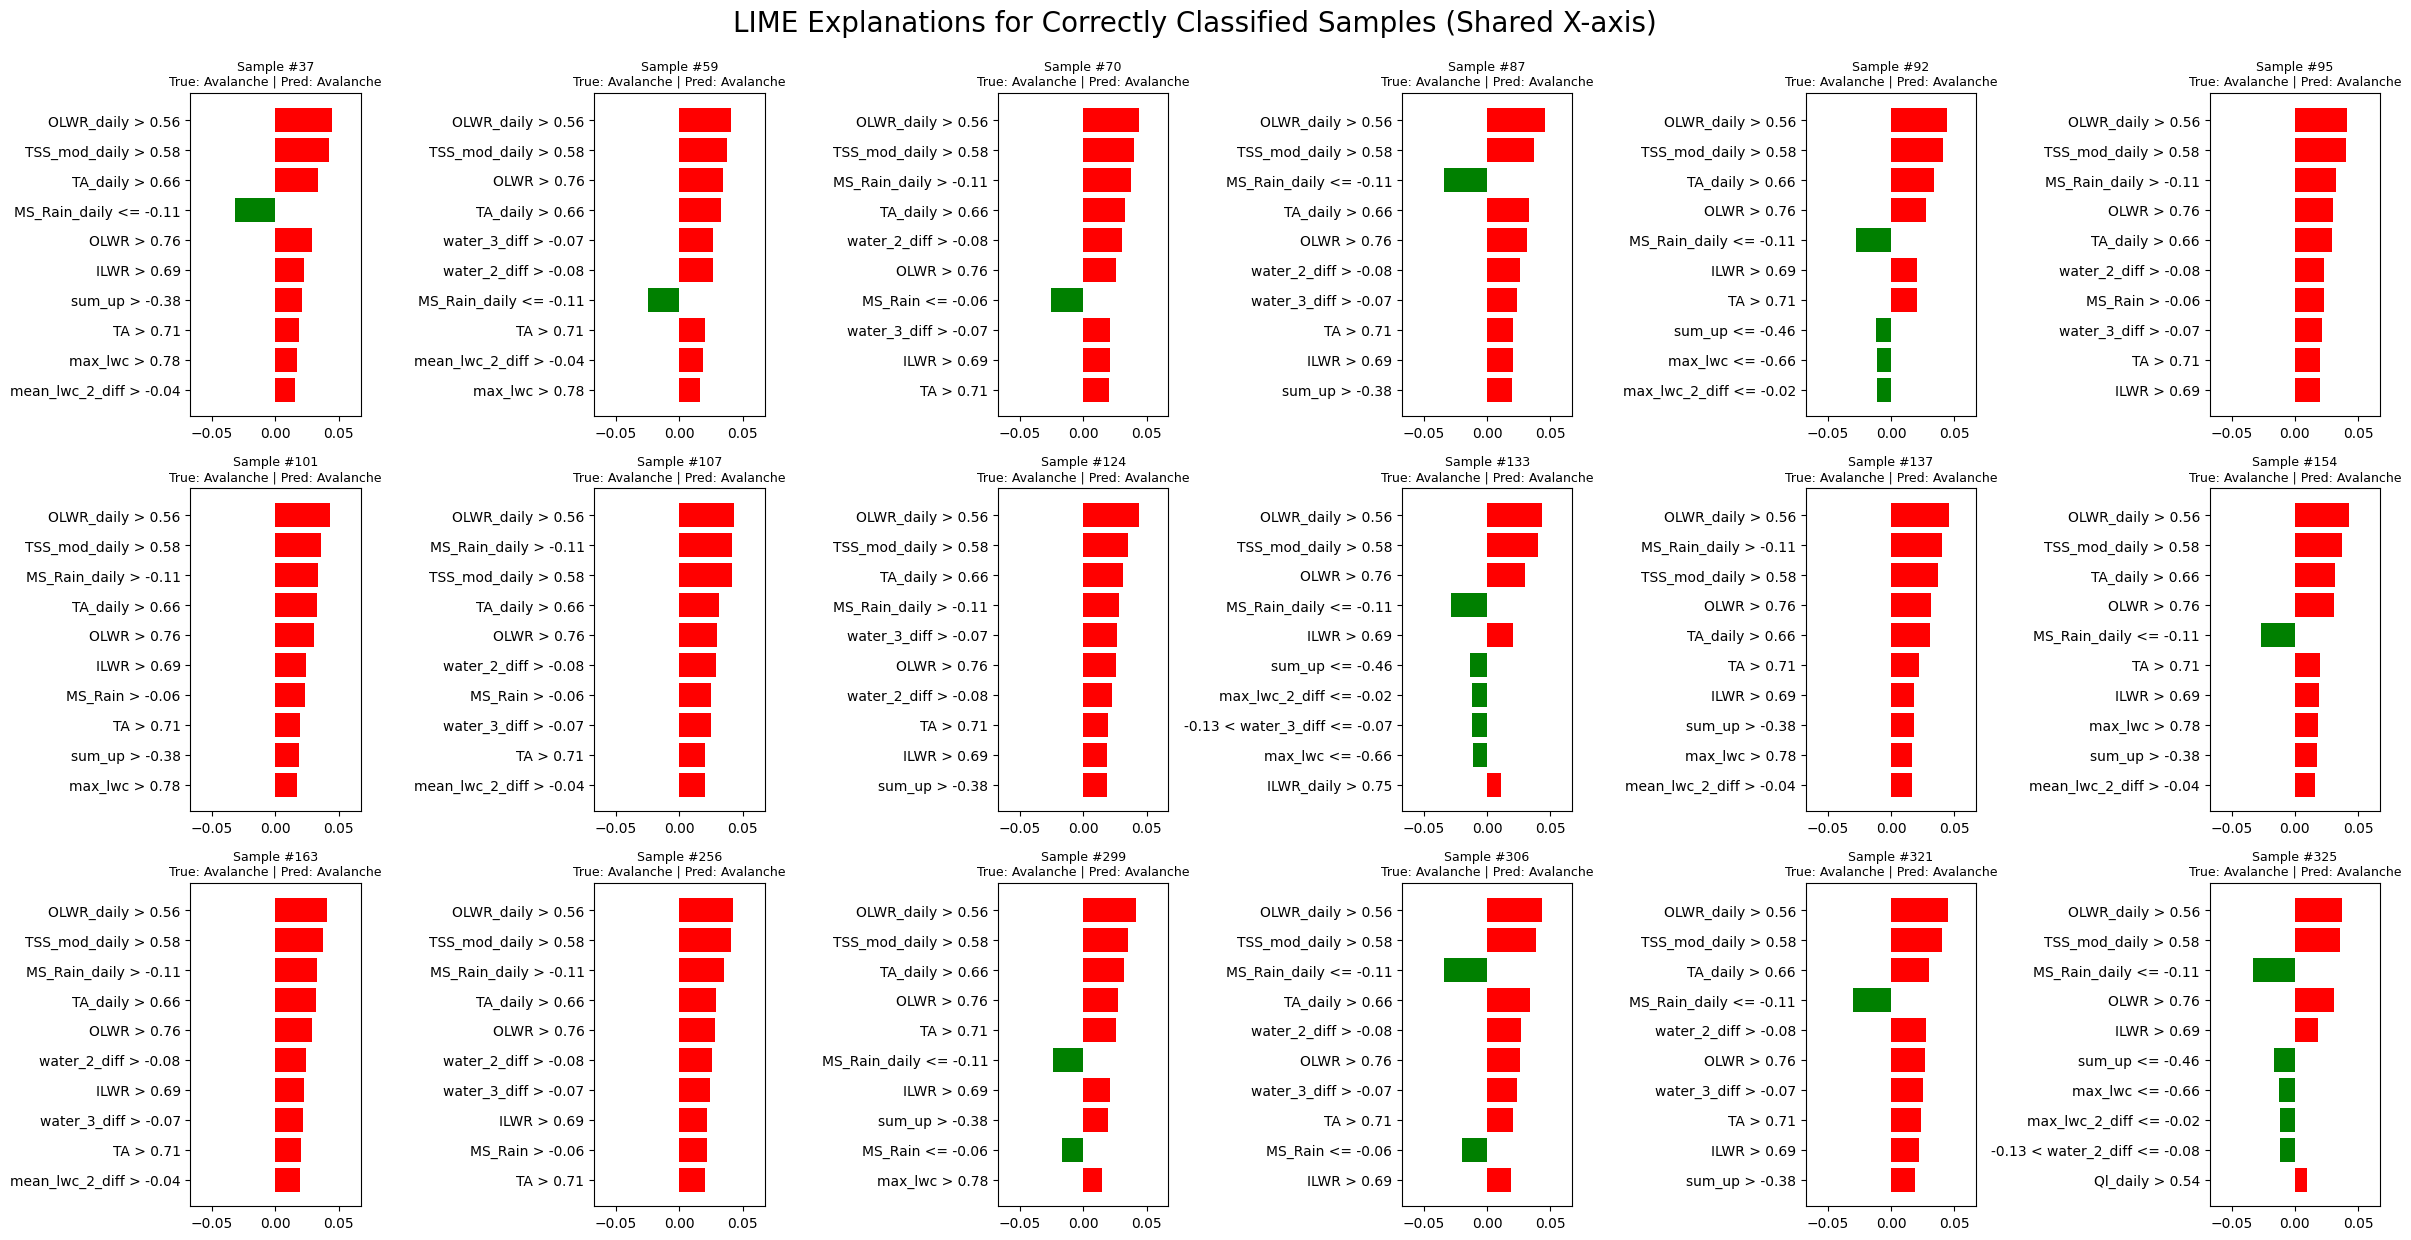

In [78]:
#Plot some more to have a look at the correctly predicted avalanches 
import matplotlib.pyplot as plt

# Get indices of correctly predicted **Avalanche** samples (True Positives)
correct_indices = np.where((y_pred_rf == 1) & (y_test.to_numpy() == 1))[0]

# Choose how many to plot
n_rows, n_cols = 3, 6
n_samples = min(len(correct_indices), n_rows * n_cols)
selected_indices = correct_indices[:n_samples]

# Step 1: Collect all weights to find shared x-axis range
all_weights = []
for i in selected_indices:
    exp = explainer.explain_instance(X_test_scaled[i], clf_rf.predict_proba, num_features=10)
    weights = [w for _, w in exp.as_list(label=exp.available_labels()[0])]
    all_weights.extend(weights)

# Shared x-axis range
global_max = max(abs(w) for w in all_weights)

# Step 2: Create grid of LIME plots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 12))
axes = axes.flatten()

for idx, i in enumerate(selected_indices):
    true_label = y_test.iloc[i]
    predicted_label = y_pred_rf[i]

    exp = explainer.explain_instance(X_test_scaled[i], clf_rf.predict_proba, num_features=10)
    explanation = exp.as_list(label=exp.available_labels()[0])
    features = [f for f, _ in explanation]
    weights = [w for _, w in explanation]

    # Horizontal bar plot
    axes[idx].barh(features, weights, color=["green" if w < 0 else "red" for w in weights])
    axes[idx].set_xlim(-global_max - 0.02, global_max + 0.02)
    axes[idx].set_title(
        f"Sample #{i}\nTrue: {'Avalanche' if true_label == 1 else 'No Avalanche'} | Pred: {'Avalanche' if predicted_label == 1 else 'No Avalanche'}",
        fontsize=9
    )
    axes[idx].invert_yaxis()

# Hide unused subplots
for j in range(n_samples, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("LIME Explanations for Correctly Classified Samples (Shared X-axis)", fontsize=20, y=1.03)
plt.show()

In [80]:
#Do LIME with ALL CORECTLY PREDICTED AVALANCHES test indices
#LIME explanations are local → they’re specific to one sample only

from collections import Counter

# True positives: correctly predicted avalanche days
true_positive_indices = np.where((y_pred_rf == 1) & (y_test.to_numpy() == 1))[0]

# Limit to 100 or fewer if needed
selected_indices = true_positive_indices[:100]

feature_counts = Counter()

for i in selected_indices:
    exp = explainer.explain_instance(X_test_scaled[i], clf_rf.predict_proba, num_features=10)
    top_features = [feature for feature, _ in exp.as_list()[:10]]  # Optional: top 3 only
    feature_counts.update(top_features)

# Display most common influential features
print("\n Most Frequent Features in Correct Avalanche Predictions:")
for feature, count in feature_counts.most_common(20):
    print(f"{feature:50s} → {count} times")

# Red bars show features pushing the prediction toward “Avalanche”.
# Green bars show features pushing toward “No Avalanche”.

# Most features were red ("Avalanche"), but the green ones ("No Avalanche") had stronger weights, so the final prediction was "No Avalanche".

#TO DO?
#Apply this to false negatives to understand what went wrong


#=== Explanation for Test Sample #0 ===
# This is one individual day that your Random Forest model was asked to classify: Will an avalanche happen or not?

#Feature values for this day:
#Actual values used by the model to make the prediction for this day.

#Name: 11157, Length: 488, dtype: object
#True label: No Avalanche #The truth (real label) for this day is 0 = No Avalanche
    
#PROBLEM:
#Datum_... are being treated as features, which is why LIME is using them
#— but they are not actual physical/meteorological features like temperature, snow height, etc.
#LIME: Model is relying on specific dates, which it shouldn’t ==> it overfits


# SO WE NEED TO?!?!?: 
# Drop datum at the beginning

#GOAL
#Avoid polluting your model with date-specific variables
#Make LIME and RF focus on actual environmental conditions
#Improve generalization across winters and stations

# Even though datum_... are not important globally (see RF's global importance), they can still dominate individual predictions (NOT GOOD?!?)


#ONLY include the numerical values!


 Most Frequent Features in Correct Avalanche Predictions:
OLWR_daily > 0.56                                  → 100 times
TSS_mod_daily > 0.58                               → 100 times
OLWR > 0.76                                        → 99 times
TA_daily > 0.66                                    → 97 times
TA > 0.71                                          → 94 times
ILWR > 0.69                                        → 82 times
water_3_diff > -0.07                               → 71 times
water_2_diff > -0.08                               → 69 times
sum_up > -0.38                                     → 59 times
MS_Rain_daily > -0.11                              → 58 times
max_lwc > 0.78                                     → 50 times
MS_Rain_daily <= -0.11                             → 42 times
mean_lwc_2_diff > -0.04                            → 27 times
MS_Rain <= -0.06                                   → 17 times
MS_Rain > -0.06                                    → 14 times
sum_up <=

In [81]:
#Take only top 3 featues with the biggest weight
from collections import Counter

# True positives: correctly predicted avalanche days
true_positive_indices = np.where((y_pred_rf == 1) & (y_test.to_numpy() == 1))[0]

# Limit to 100 or fewer if needed
selected_indices = true_positive_indices[:100]

feature_counts = Counter()

for i in selected_indices:
    exp = explainer.explain_instance(X_test_scaled[i], clf_rf.predict_proba, num_features=10)
    top_features = [feature for feature, _ in exp.as_list()[:3]]  # Optional: top 3 only
    feature_counts.update(top_features)

# Display most common influential features
print("\n TOP 3 Most Frequent Features in Correct Avalanche Predictions:")
for feature, count in feature_counts.most_common(20):
    print(f"{feature:50s} -> {count} times")



 Most Frequent Features in Correct Avalanche Predictions:
OLWR_daily > 0.56                                  -> 100 times
TSS_mod_daily > 0.58                               -> 100 times
MS_Rain_daily > -0.11                              -> 43 times
TA_daily > 0.66                                    -> 31 times
MS_Rain_daily <= -0.11                             -> 18 times
OLWR > 0.76                                        -> 8 times


18

=== Misclassified Test Sample #68 ===
True Label     : Avalanche
Predicted Label: No Avalanche

Feature values for this day:
aspect                 4.00
elevation           2677.00
max_height            60.82
TSS_mod                0.00
prop_base_3_diff       0.00
                     ...   
water_1_diff           5.20
sum_base_2_diff        0.00
MS_Rain_daily          0.00
MS_Rain                0.00
year                2005.00
Name: 3623, Length: 85, dtype: float64


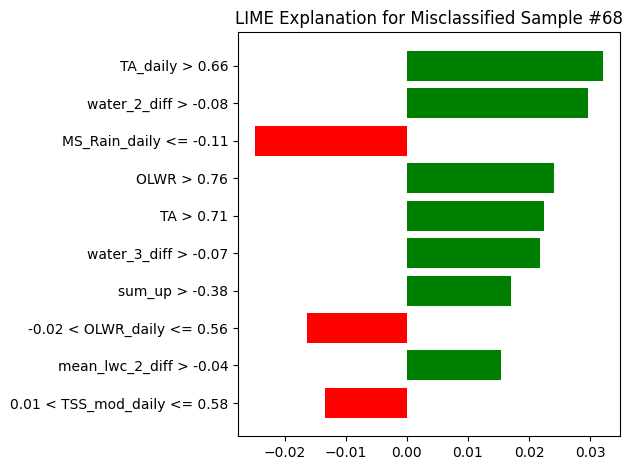


=== Misclassified Test Sample #201 ===
True Label     : Avalanche
Predicted Label: No Avalanche

Feature values for this day:
aspect                 3.000
elevation           2252.000
max_height           351.930
TSS_mod                0.000
prop_base_3_diff       0.000
                      ...   
water_1_diff          47.100
sum_base_2_diff        0.000
MS_Rain_daily          0.386
MS_Rain                0.658
year                2020.000
Name: 1380, Length: 85, dtype: float64


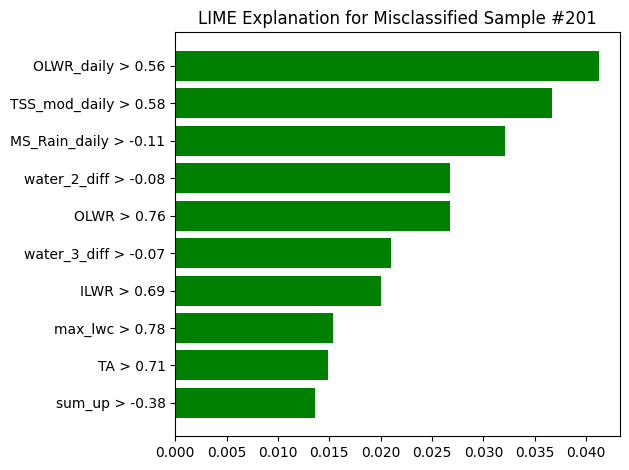


=== Misclassified Test Sample #446 ===
True Label     : No Avalanche
Predicted Label: Avalanche

Feature values for this day:
aspect                 3.0000
elevation           2063.0000
max_height            47.8800
TSS_mod                0.0000
prop_base_3_diff       0.0000
                      ...    
water_1_diff         -21.3000
sum_base_2_diff        0.0000
MS_Rain_daily          0.0015
MS_Rain                0.0000
year                2005.0000
Name: 1469, Length: 85, dtype: float64


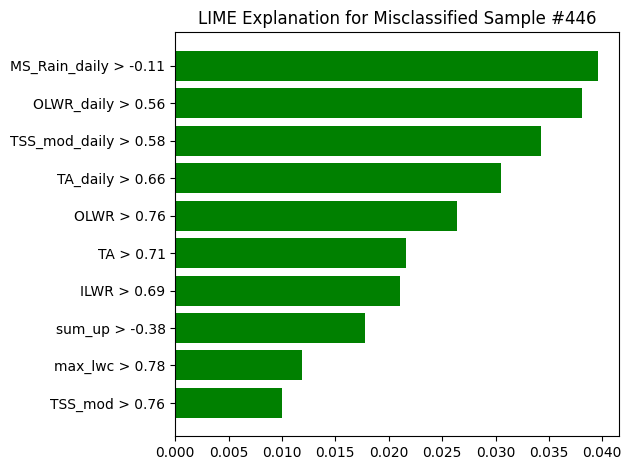


=== Misclassified Test Sample #540 ===
True Label     : Avalanche
Predicted Label: No Avalanche

Feature values for this day:
aspect                 1.00
elevation           2290.00
max_height           186.33
TSS_mod                0.00
prop_base_3_diff       0.00
                     ...   
water_1_diff          -0.20
sum_base_2_diff        0.00
MS_Rain_daily          0.00
MS_Rain                0.00
year                2022.00
Name: 9536, Length: 85, dtype: float64


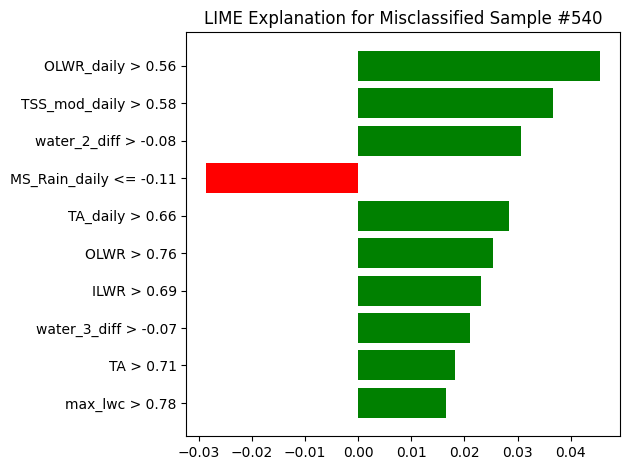


=== Misclassified Test Sample #549 ===
True Label     : No Avalanche
Predicted Label: Avalanche

Feature values for this day:
aspect                 3.00
elevation           2536.00
max_height            90.13
TSS_mod                0.00
prop_base_3_diff       1.00
                     ...   
water_1_diff          50.10
sum_base_2_diff       59.20
MS_Rain_daily          0.00
MS_Rain                0.00
year                2020.00
Name: 3503, Length: 85, dtype: float64


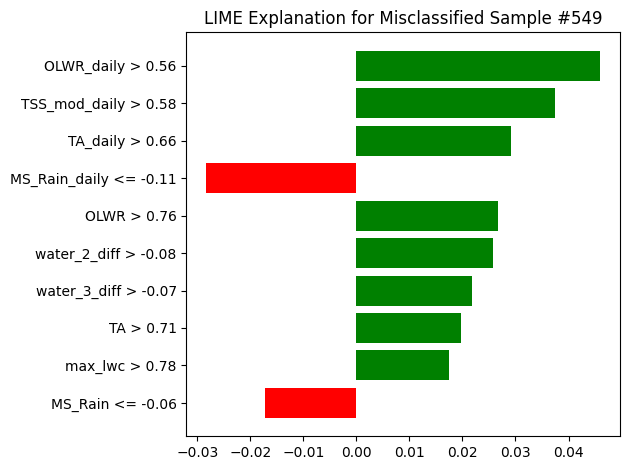


=== Misclassified Test Sample #614 ===
True Label     : Avalanche
Predicted Label: No Avalanche

Feature values for this day:
aspect                 3.000000
elevation           2388.000000
max_height            75.530000
TSS_mod                0.000000
prop_base_3_diff       0.686924
                       ...     
water_1_diff         -11.400000
sum_base_2_diff        9.300000
MS_Rain_daily          0.000000
MS_Rain                0.000000
year                2021.000000
Name: 5207, Length: 85, dtype: float64


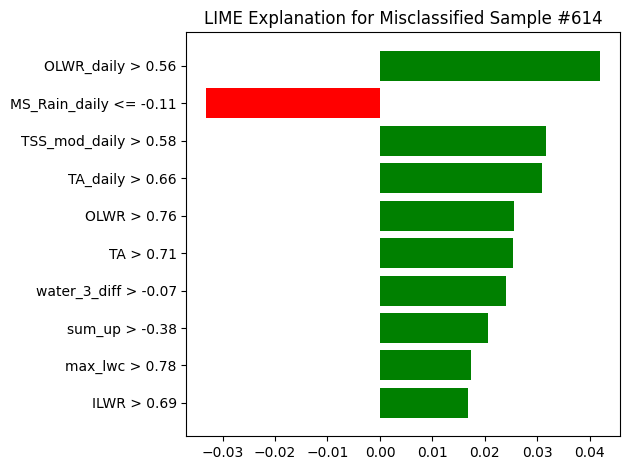


=== Misclassified Test Sample #651 ===
True Label     : Avalanche
Predicted Label: No Avalanche

Feature values for this day:
aspect                 4.00000
elevation           2558.00000
max_height            94.44000
TSS_mod              -18.75800
prop_base_3_diff      -0.00077
                       ...    
water_1_diff          -1.70000
sum_base_2_diff       -3.10000
MS_Rain_daily          0.00000
MS_Rain                0.00000
year                2020.00000
Name: 454, Length: 85, dtype: float64


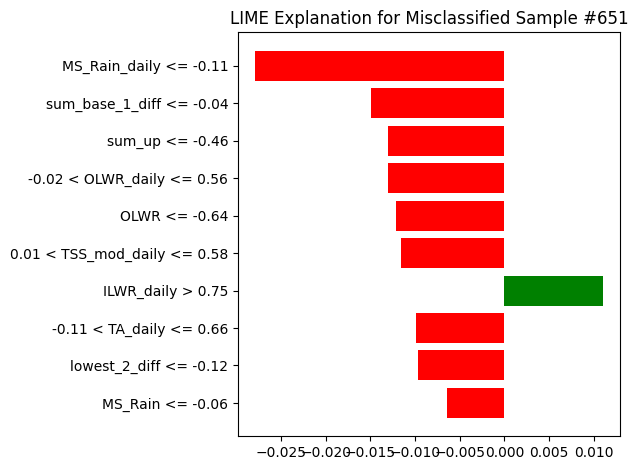


=== Misclassified Test Sample #845 ===
True Label     : Avalanche
Predicted Label: No Avalanche

Feature values for this day:
aspect                 4.00
elevation           2147.00
max_height            54.68
TSS_mod                0.00
prop_base_3_diff       0.00
                     ...   
water_1_diff         -11.10
sum_base_2_diff       -0.40
MS_Rain_daily          0.00
MS_Rain                0.00
year                2021.00
Name: 8923, Length: 85, dtype: float64


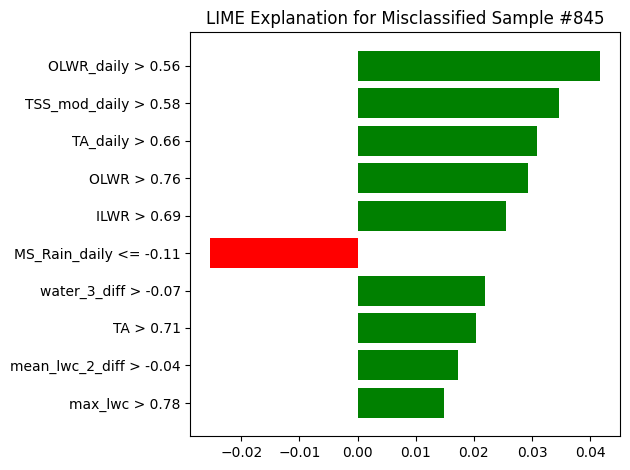


=== Misclassified Test Sample #1012 ===
True Label     : Avalanche
Predicted Label: No Avalanche

Feature values for this day:
aspect                 1.000
elevation           2558.000
max_height            74.740
TSS_mod               -3.988
prop_base_3_diff       0.000
                      ...   
water_1_diff           0.000
sum_base_2_diff        0.000
MS_Rain_daily          0.000
MS_Rain                0.000
year                2021.000
Name: 9752, Length: 85, dtype: float64


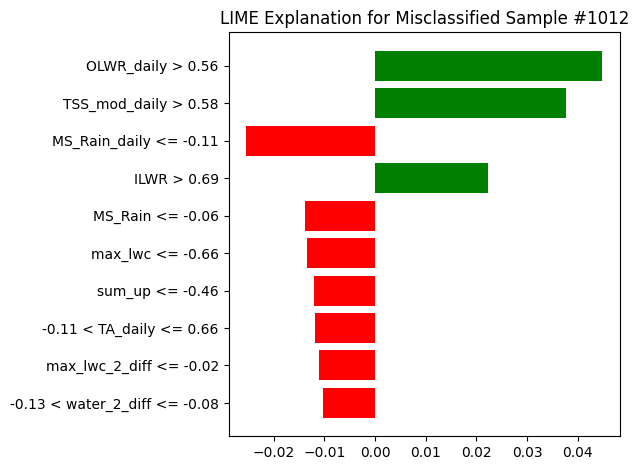


=== Misclassified Test Sample #1131 ===
True Label     : Avalanche
Predicted Label: No Avalanche

Feature values for this day:
aspect                 2.0
elevation           2455.0
max_height           185.2
TSS_mod                0.0
prop_base_3_diff       0.0
                     ...  
water_1_diff          10.0
sum_base_2_diff        0.0
MS_Rain_daily          0.0
MS_Rain                0.0
year                2022.0
Name: 11053, Length: 85, dtype: float64


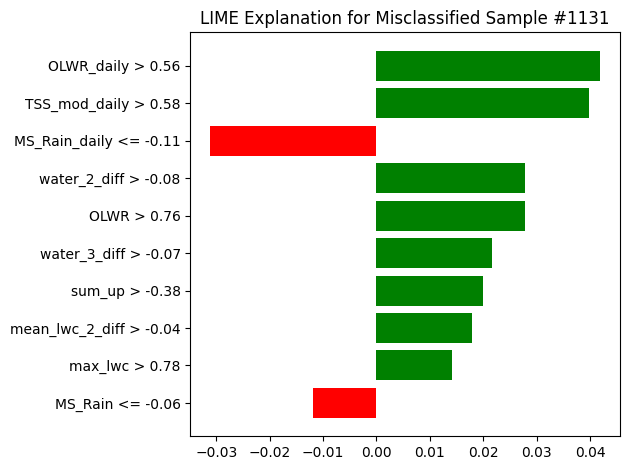


=== Misclassified Test Sample #1134 ===
True Label     : Avalanche
Predicted Label: No Avalanche

Feature values for this day:
aspect                 1.00
elevation           2330.00
max_height           241.98
TSS_mod                0.00
prop_base_3_diff       0.00
                     ...   
water_1_diff           2.50
sum_base_2_diff        0.00
MS_Rain_daily          0.00
MS_Rain                0.00
year                2021.00
Name: 5963, Length: 85, dtype: float64


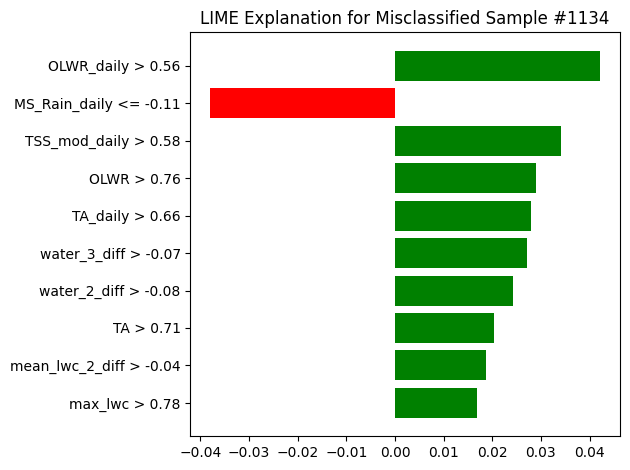


=== Misclassified Test Sample #1215 ===
True Label     : Avalanche
Predicted Label: No Avalanche

Feature values for this day:
aspect                 2.00
elevation           2147.00
max_height           183.77
TSS_mod                0.00
prop_base_3_diff       0.00
                     ...   
water_1_diff         -14.40
sum_base_2_diff       -0.10
MS_Rain_daily          0.00
MS_Rain                0.00
year                2009.00
Name: 1941, Length: 85, dtype: float64


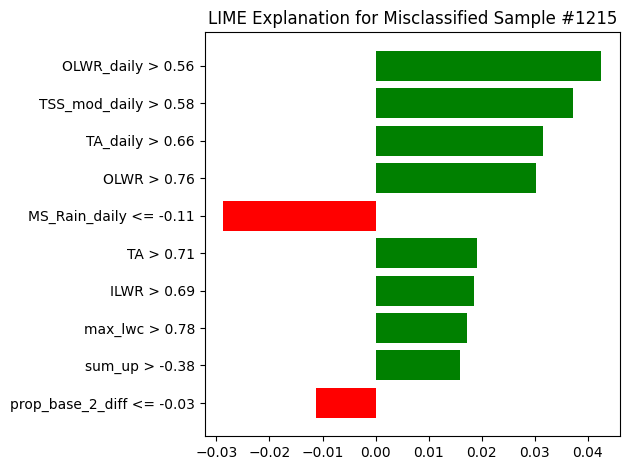


=== Misclassified Test Sample #1366 ===
True Label     : Avalanche
Predicted Label: No Avalanche

Feature values for this day:
aspect                 4.00
elevation           2426.00
max_height           126.56
TSS_mod                0.00
prop_base_3_diff       0.00
                     ...   
water_1_diff           3.90
sum_base_2_diff       -4.70
MS_Rain_daily          0.00
MS_Rain                0.00
year                2009.00
Name: 1861, Length: 85, dtype: float64


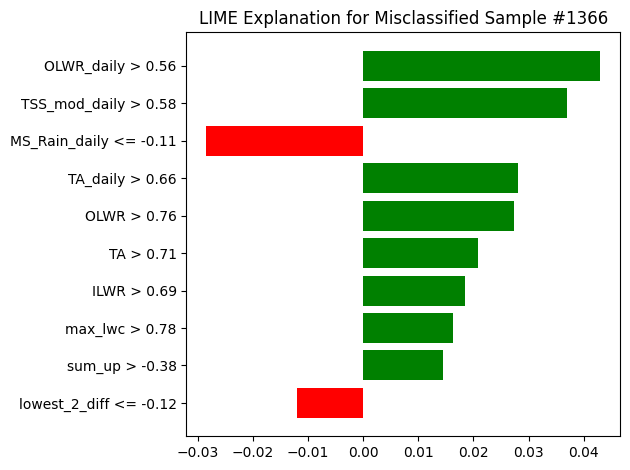


=== Misclassified Test Sample #1414 ===
True Label     : Avalanche
Predicted Label: No Avalanche

Feature values for this day:
aspect                 3.00
elevation           2063.00
max_height            94.46
TSS_mod                0.00
prop_base_3_diff       0.00
                     ...   
water_1_diff          -8.20
sum_base_2_diff        0.00
MS_Rain_daily          0.00
MS_Rain                0.00
year                2021.00
Name: 4118, Length: 85, dtype: float64


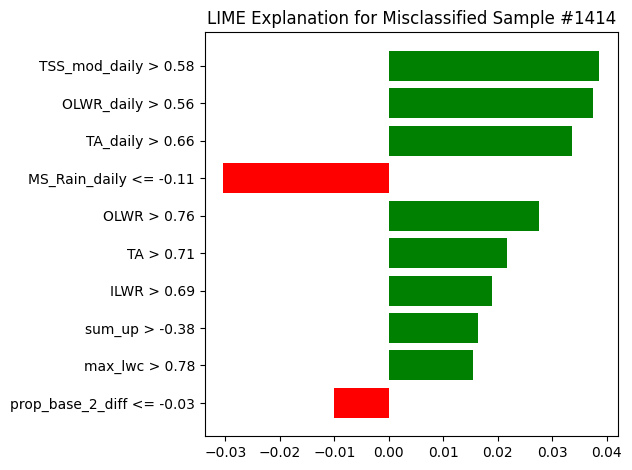


=== Misclassified Test Sample #1659 ===
True Label     : Avalanche
Predicted Label: No Avalanche

Feature values for this day:
aspect                 4.00
elevation           2394.00
max_height           232.97
TSS_mod                0.00
prop_base_3_diff       0.00
                     ...   
water_1_diff         -30.90
sum_base_2_diff        0.00
MS_Rain_daily          0.00
MS_Rain                0.00
year                2021.00
Name: 7706, Length: 85, dtype: float64


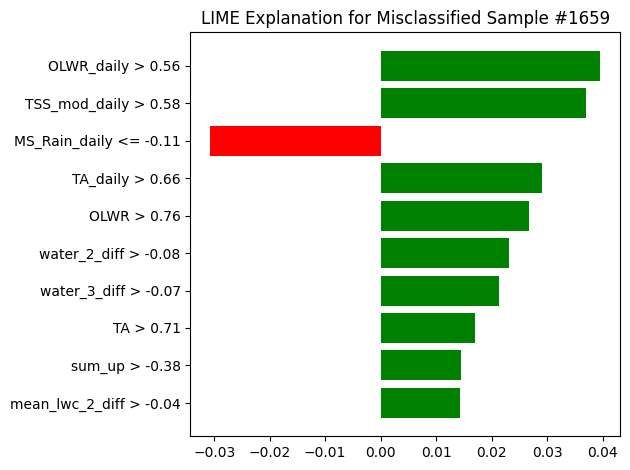


=== Misclassified Test Sample #1910 ===
True Label     : Avalanche
Predicted Label: No Avalanche

Feature values for this day:
aspect                 2.00
elevation           2512.00
max_height           223.95
TSS_mod               -8.35
prop_base_3_diff       0.00
                     ...   
water_1_diff          -1.00
sum_base_2_diff        0.00
MS_Rain_daily          0.00
MS_Rain                0.00
year                2021.00
Name: 6691, Length: 85, dtype: float64


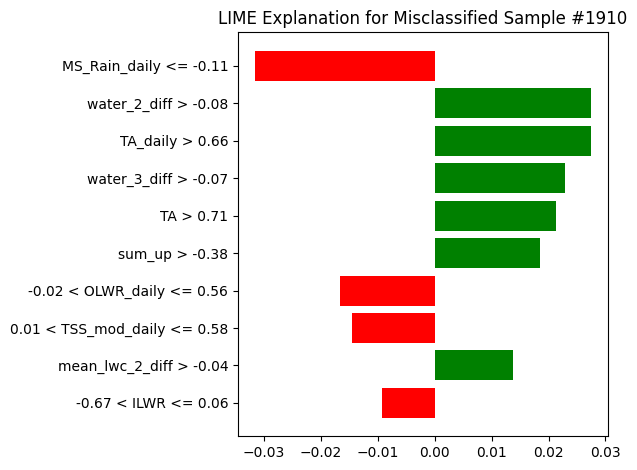


=== Misclassified Test Sample #1930 ===
True Label     : Avalanche
Predicted Label: No Avalanche

Feature values for this day:
aspect              3.000000e+00
elevation           2.558000e+03
max_height          1.404500e+02
TSS_mod             0.000000e+00
prop_base_3_diff   -1.110223e-16
                        ...     
water_1_diff       -5.684342e-14
sum_base_2_diff    -1.000000e-01
MS_Rain_daily       0.000000e+00
MS_Rain             0.000000e+00
year                2.021000e+03
Name: 4748, Length: 85, dtype: float64


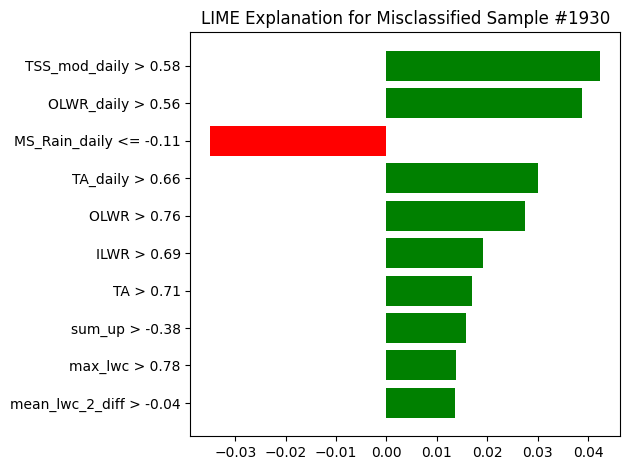


=== Misclassified Test Sample #1995 ===
True Label     : Avalanche
Predicted Label: No Avalanche

Feature values for this day:
aspect                 1.000
elevation           2726.000
max_height           188.620
TSS_mod                0.000
prop_base_3_diff       0.000
                      ...   
water_1_diff          11.100
sum_base_2_diff        0.000
MS_Rain_daily          0.051
MS_Rain                0.340
year                2020.000
Name: 691, Length: 85, dtype: float64


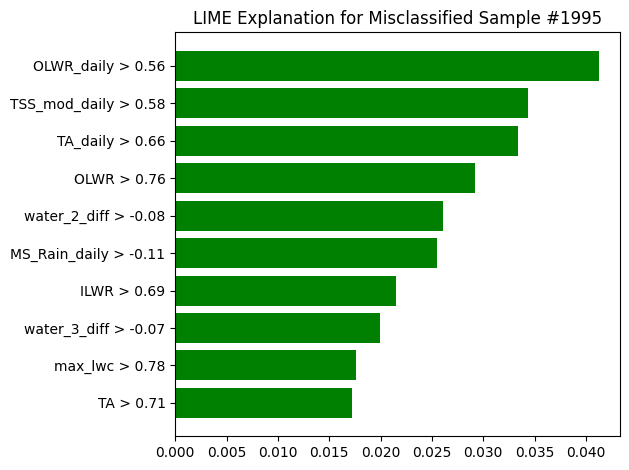

In [64]:
#Find the missclassified ones and check with LIME what their features are
import matplotlib.pyplot as plt

#Find missclassifications
y_test_array = y_test.to_numpy()
misclassified_indices = np.where(y_pred_rf != y_test_array)[0]
print(len(misclassified_indices)) #found all 18

# Loop over each misclassified sample and run LIME
for i in misclassified_indices:
    print(f"\n=== Misclassified Test Sample #{i} ===")
    
    # Ground truth and prediction
    true_label = y_test.iloc[i]
    predicted_label = y_pred_rf[i]
    print(f"True Label     : {'Avalanche' if true_label == 1 else 'No Avalanche'}")
    print(f"Predicted Label: {'Avalanche' if predicted_label == 1 else 'No Avalanche'}")

    # Feature values for this day
    print("\nFeature values for this day:")
    print(X_test.iloc[i])

    # LIME explanation
    exp = explainer.explain_instance(X_test_scaled[i], clf_rf.predict_proba, num_features=10)

    # Show barplot explanation
    fig = exp.as_pyplot_figure()
    plt.title(f"LIME Explanation for Misclassified Sample #{i}")
    plt.tight_layout()
    plt.show()



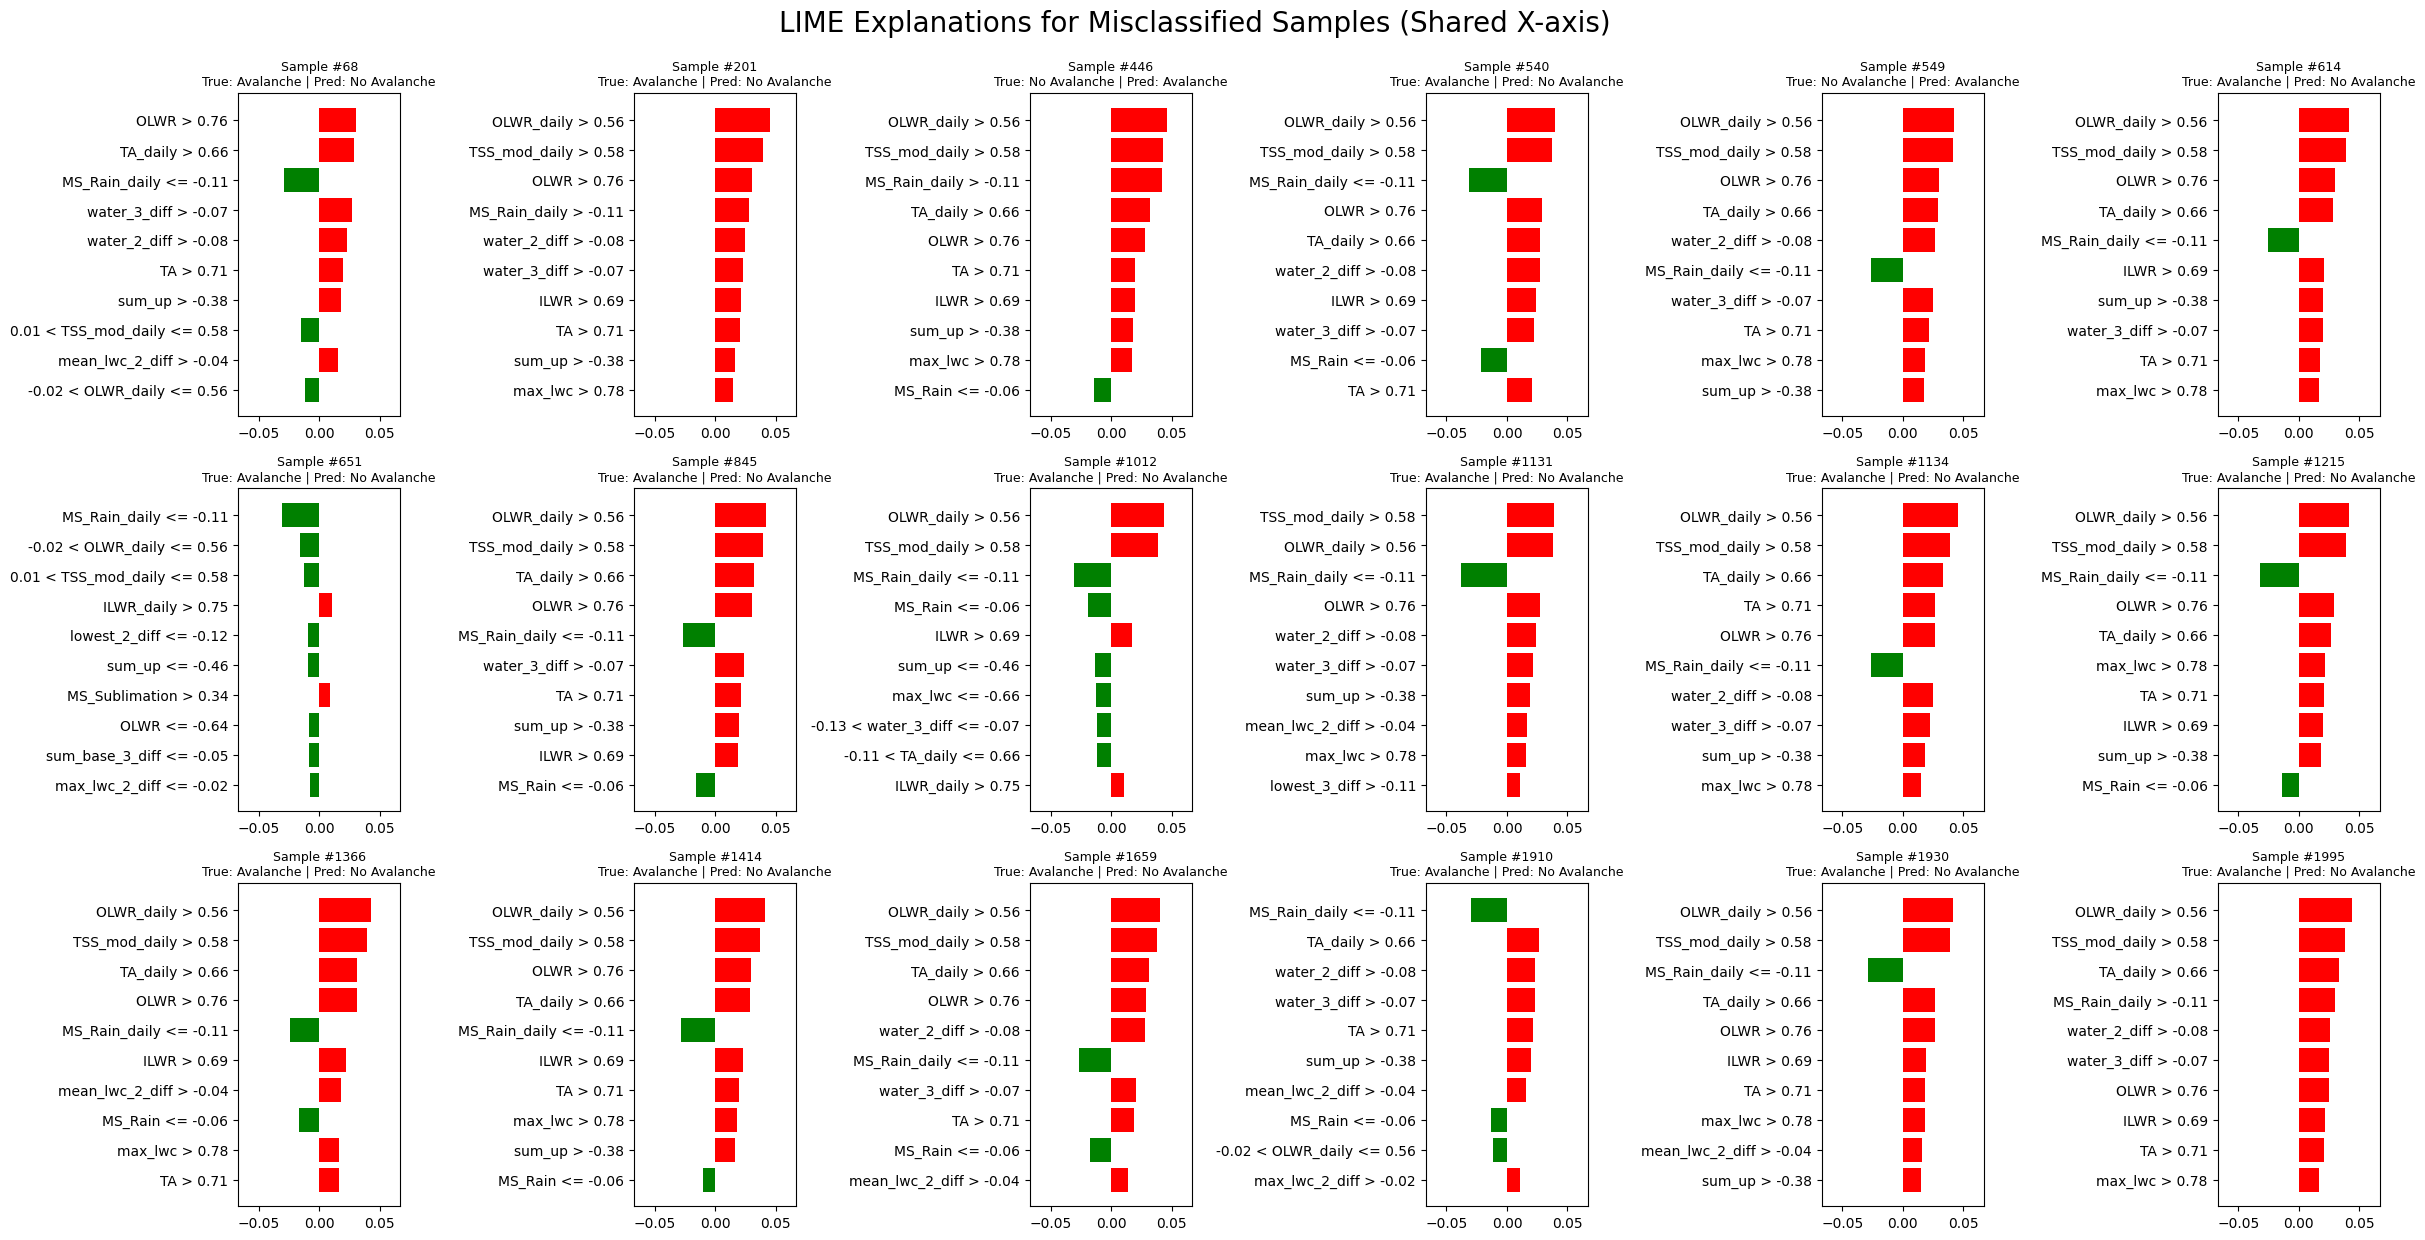

In [71]:
# Step 1: Collect all weights first to find global max
all_weights = []

for i in misclassified_indices:
    exp = explainer.explain_instance(X_test_scaled[i], clf_rf.predict_proba, num_features=10)
    weights = [w for _, w in exp.as_list(label=exp.available_labels()[0])]
    all_weights.extend(weights)

# Step 2: Set consistent x-axis limits across all plots
global_max = max(abs(w) for w in all_weights)

# Step 3: Plot with shared x-limits
fig, axes = plt.subplots(3, 6, figsize=(24, 12))
axes = axes.flatten()

for idx, i in enumerate(misclassified_indices):
    if idx >= len(axes):
        break

    true_label = y_test.iloc[i]
    predicted_label = y_pred_rf[i]
    exp = explainer.explain_instance(X_test_scaled[i], clf_rf.predict_proba, num_features=10)
    explanation = exp.as_list(label=exp.available_labels()[0])
    features = [x[0] for x in explanation]
    weights = [x[1] for x in explanation]

    axes[idx].barh(features, weights, color=['green' if w < 0 else 'red' for w in weights])
    axes[idx].set_xlim(-global_max - 0.02, global_max + 0.02)
    axes[idx].set_title(f"Sample #{i}\nTrue: {'Avalanche' if true_label == 1 else 'No Avalanche'} | Pred: {'Avalanche' if predicted_label == 1 else 'No Avalanche'}", fontsize=9)
    axes[idx].invert_yaxis()

# Hide unused subplots
for j in range(len(misclassified_indices), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.suptitle("LIME Explanations for Misclassified Samples (Shared X-axis)", fontsize=20, y=1.03)
plt.show()


In [74]:
# Find that a few features consistently lead to false negatives or false positives 
# !!! those are candidates for better preprocessing, feature engineering, or rebalancing !!!

#Count the top 3 per wrong prediction

from collections import Counter

top3_counter = Counter()

# Loop over misclassified samples
for i in misclassified_indices:
    # Run LIME
    exp = explainer.explain_instance(X_test_scaled[i], clf_rf.predict_proba, num_features=10)
    # Get top 3 features
    top3_features = [feature for feature, weight in exp.as_list(label=exp.available_labels()[0])[:3]]
    # Count them
    top3_counter.update(top3_features)

# Print the top most common features across misclassifications
print("\n Most Frequent Top-3 Features in Misclassified Samples:")
for feature, count in top3_counter.most_common(10):
    print(f"{feature:40s} ==> {count} times")



 Most Frequent Top-3 Features in Misclassified Samples:
OLWR_daily > 0.56                        ==> 15 times
TSS_mod_daily > 0.58                     ==> 15 times
MS_Rain_daily <= -0.11                   ==> 8 times
TA_daily > 0.66                          ==> 8 times
OLWR > 0.76                              ==> 3 times
water_2_diff > -0.08                     ==> 2 times
-0.11 < TA_daily <= 0.66                 ==> 1 times
OLWR <= -0.64                            ==> 1 times
MS_Rain_daily > -0.11                    ==> 1 times


# LIMITATIONS:

1) Imbalanced Classes
Avalanche days are rare → models tend to favor the majority class

You tackled this well by evaluating recall, not just accuracy.

Consider also: class_weight='balanced' in your classifier

Upsampling avalanche days (SMOTE, etc.)

2) No Temporal Component
You treat each day as independent.

In reality, snowpack conditions evolve — so time-series models (like LSTMs) could perform better.

3) LIME is Local
LIME only explains one instance at a time.

It’s useful for individual decision-making, but doesn’t show global model behavior.

For global insights, SHAP is more robust.

4) No Uncertainty Estimates
Your model gives probabilities, but no confidence intervals.

Explainable AI

Logistic regressin,... (Black box) - AI makes blackbox as clear as possible!!!
LIME sheds light on what the random forest does

Bring the human in the loop - propose it (bring the humans in the loop)

Machine learning is nice - but also enter the human into the system

!!!NOW understand the LWC better!!!

Computer vision task 
Neural network stuff
resonses (3 sensors - 20 differnt bands per sensor) 10 to 30 m resolutions 
Which bands do we need!

10 m - 30 m (mean values form stations) - fit it to the model

script -> loction -> 1 GB foto per location

Find datasets time series fotos of switerland (targetet at LWC)
Which bands to we need - how to extract the LWC

Download Archive
Have 3 bands - usefull Bo5 Bo6
Open it with pyhton code (module)
What are the coordinates of and point
Extract mean of one region around a station (9 pixel)
Station - Coordinate - Mean value band 1 - Mean value band 2 - ... - Slope - 

Extraced LWC pixcel by pixel dataset 

Np.array (how to load the mean around a station)

If mean approach does not work at all - need computer vision (supervises learning)
